# 1. 数据预处理

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 读取数据
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# 合并训练数据和测试数据（不包括目标列）
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print("All features shape after concat:", all_features.shape)

# 处理数值特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print("Numeric features:", numeric_features)

# 标准化数值特征
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std())

# 在标准化数据之后，将缺失值填充为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 独热编码分类特征，并将缺失值视为有效的特征值
all_features = pd.get_dummies(all_features, dummy_na=True)
print("All features shape after get_dummies:", all_features.shape)

# 确保所有列的数据类型都是 float32
all_features = all_features.astype(np.float32)

# 打印特征的数据类型，检查是否所有特征都是数值类型
print(all_features.dtypes)

# 转换为PyTorch张量
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)
print("Train labels shape:", train_labels.shape)


Train data shape: (1460, 81)
Test data shape: (1459, 80)
All features shape after concat: (2919, 79)
Numeric features: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
All features shape after get_dummies: (2919, 330)
MSSubClass               float32
LotFrontage              float32
LotArea                  float32
OverallQual              float32
OverallCond              float32
                          ...   
SaleCondition_Alloca     float32
SaleCondition_Family 

# 2. 训练

## 2.1 定义模型

In [12]:
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 64)
        self.hidden3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x
    

In [13]:
batch_size = 64
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_features)

tensor([[ 0.0673, -0.1844, -0.2178,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673, -0.0559,  0.1372,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]])


## 2.3 损失函数和优化器

In [14]:
# 定义损失函数
class RelativeErrorLoss(nn.Module):
    def __init__(self):
        super(RelativeErrorLoss, self).__init__()

    def forward(self, preds, labels):
        relative_error = torch.abs(preds - labels) / torch.abs(labels)
        return torch.mean(relative_error)

loss_fn = RelativeErrorLoss()


## 2.4 训练

Final Loss: 0.0620


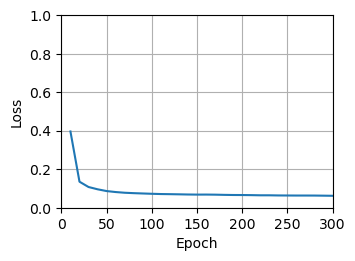

In [15]:
# 导入 Animator 模块
from animator import Animator

# 初始化模型和优化器
in_features = train_features.shape[1]
model = HousePriceModel(in_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300

# 使用 Animator 动态绘图
animator = Animator(xlabel='Epoch', ylabel='Loss', xlim=[0, num_epochs], ylim=[0, 1])

# 训练过程
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X, y in train_loader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
            
        # 添加损失到动画
        animator.add(epoch + 1, epoch_loss)
        

# 打印最终损失
print(f'Final Loss: {epoch_loss:.4f}')

In [16]:
# 评估模型并生成提交文件
model.eval()
with torch.no_grad():
    test_preds = model(test_features).numpy()

submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': test_preds.flatten()
})
submission.to_csv('submission_mlp.csv', index=False)